# Introduction to BigQuery ML - Predict Birth Weight

**Learning Objectives**

In this lab, you learn to perform the following tasks:

- Use BigQuery to explore the natality dataset
- Create a training and evaluation dataset for prediction
- Create a regression (linear regression) model in BQML
- Evaluate the performance of your machine learning model

___

## Introduction 

In this lab, you will be using the US Centers for Disease Control and Prevention's (CDC) natality data to build a model to predict baby birth weights based on a handful of features known at pregnancy. Because you are predicting a continuous value, this is a regression problem, and for that, you will use the linear regression model built into BQML.

---

### Set up the notebook environment

__VERY IMPORTANT__:  In the cell below you must replace the text 'QWIKLABSPROJECT' with your Qwiklabs Project Name as provided during the setup of your environment. Please leave any surrounding single quotes in place.

In [1]:
PROJECT = 'QWIKLABSPROJECT' #TODO Replace with your Qwiklabs PROJECT

## Exploring the Data

This lab will use natality data and training on features to predict the birth weight.

The CDC's Natality data has details on US births from 1969 to 2008 and is available in BigQuery as a public data set. More details: https://bigquery.cloud.google.com/table/publicdata:samples.natality?tab=details

Start by looking at the data since 2000 with useful values, those greater than 0.

Note:  "__%%bigquery__" is a magic which allows quick access to BigQuery from within a notebook.

In [2]:
%%bigquery 
SELECT *
FROM publicdata.samples.natality
WHERE
  year > 2000
  AND gestation_weeks > 0
  AND mother_age > 0
  AND plurality > 0
  AND weight_pounds > 0
LIMIT 10

,source_year,year,month,day,wday,state,is_male,child_race,weight_pounds,plurality,...,alcohol_use,drinks_per_week,weight_gain_pounds,born_alive_alive,born_alive_dead,born_dead,ever_born,father_race,father_age,record_weight
0,2001,2001,10,None,6,AL,False,9,5.937049,1,...,False,None,30,0,0,0,1,1,28,1
1,2001,2001,9,None,6,CA,False,9,6.874013,1,...,None,None,99,0,0,0,1,1,22,1
2,2001,2001,5,None,2,GA,False,9,8.000575,1,...,False,None,42,0,0,0,1,1,18,1
3,2001,2001,3,None,3,LA,True,9,8.062305,1,...,False,None,45,0,0,0,1,1,33,1
4,2001,2001,8,None,1,MO,False,9,7.561856,1,...,False,None,42,1,0,0,2,9,99,1
5,2001,2001,2,None,5,NJ,False,9,7.639017,2,...,False,None,58,0,0,1,1,1,35,1
6,2001,2001,4,None,4,OH,False,9,5.941458,2,...,False,None,50,0,0,0,1,1,36,1
7,2001,2001,9,None,7,OH,False,9,6.128851,1,...,False,None,24,1,0,0,2,2,31,1
8,2001,2001,1,None,3,TX,False,9,9.124933,1,...,False,None,33,1,0,0,2,1,24,1
9,2001,2001,3,None,5,TX,False,9,7.500126,1,...,False,None,25,3,0,0,4,9,99,1


## Define Features

Looking over the data set, there are a few columns of interest that could be leveraged into features for a reasonable prediction of approximate birth weight.

Further, some feature engineering may be accomplished with the BigQuery `CAST` function -- in BQML, all strings are considered categorical features and all numeric types are considered continuous ones.

The hashmonth is added so that we can repeatably split the data without leakage -- the goal is to have all babies that share a birthday to be either in training set or in test set and not spread between them (otherwise, there would be information leakage when it comes to triplets, etc.)

In [3]:
%%bigquery
SELECT
    weight_pounds, -- this is the label; because it is continuous, we need to use regression
    CAST(is_male AS STRING) AS is_male,
    mother_age,
    CAST(plurality AS STRING) AS plurality,
    gestation_weeks,
    ABS(FARM_FINGERPRINT(CONCAT(CAST(YEAR AS STRING), CAST(month AS STRING)))) AS hashmonth
FROM publicdata.samples.natality
WHERE
  year > 2000
  AND gestation_weeks > 0
  AND mother_age > 0
  AND plurality > 0
  AND weight_pounds > 0
LIMIT 10

,weight_pounds,is_male,mother_age,plurality,gestation_weeks,hashmonth
0,8.249698,true,24,1,41,6691862025345277042
1,4.312242,true,19,1,38,8904940584331855459
2,6.750554,false,35,1,42,3408502330831153141
3,8.375361,true,30,1,40,7146494315947640619
4,8.313632,true,20,1,44,1088037545023002395
5,6.131056,false,32,1,38,3408502330831153141
6,9.250597,true,28,1,41,7108882242435606404
7,10.374954,false,34,1,39,6691862025345277042
8,6.060508,false,31,1,38,1525201076796226340
9,7.352416,false,24,1,39,6392072535155213407


## Train Model

With the relevant columns chosen to accomplish predictions, it is then possible to create and train the model in BigQuery. First, a dataset will be needed store the model.

In [ ]:
%%bash
bq --location=US mk -d demo

With the demo dataset ready, it is possible to create a linear regression model to train the model.

This will take approximately **5 to 7 minutes** to run.  Feedback from BigQuery will cease in output cell and the notebook will leave the "busy" state when complete.

In [5]:
%%bigquery
CREATE or REPLACE MODEL demo.babyweight_model_asis
OPTIONS
  (model_type='linear_reg', labels=['weight_pounds'], optimize_strategy='batch_gradient_descent') AS
  
WITH natality_data AS (
  SELECT
    weight_pounds,-- this is the label; because it is continuous, we need to use regression
    CAST(is_male AS STRING) AS is_male,
    mother_age,
    CAST(plurality AS STRING) AS plurality,
    gestation_weeks,
    ABS(FARM_FINGERPRINT(CONCAT(CAST(YEAR AS STRING), CAST(month AS STRING)))) AS hashmonth
  FROM
    publicdata.samples.natality
  WHERE
    year > 2000
    AND gestation_weeks > 0
    AND mother_age > 0
    AND plurality > 0
    AND weight_pounds > 0
)

SELECT
    weight_pounds,
    is_male,
    mother_age,
    plurality,
    gestation_weeks
FROM
    natality_data
WHERE
  MOD(hashmonth, 4) < 3  -- select 75% of the data as training

""


## Training Statistics

For all training runs, statistics are captured in the "TRAINING_INFO" table. This table has basic performance statistics for each iteration.

The query below returns the training details.

In [6]:
%%bigquery
SELECT * FROM ML.TRAINING_INFO(MODEL demo.babyweight_model_asis);

,training_run,iteration,loss,eval_loss,learning_rate,duration_ms
0,0,5,1.130779,1.130047,0.4,35829
1,0,4,1.132380,1.131636,0.8,63862
2,0,3,1.143513,1.143927,0.4,35106
3,0,2,1.179019,1.179471,0.4,36204
4,0,1,1.572833,1.576313,0.4,35439
5,0,0,9.855745,9.846956,0.2,21791


Some of these columns are obvious although what do the non-specific ML columns mean (specific to BQML)?

**training_run** - Will be zero for a newly created model. If the model is re-trained using warm_start, this will increment for each re-training.

**iteration** - Number of the associated `training_run`, starting with zero for the first iteration.

**duration_ms** - Indicates how long the iteration took (in ms).

Next plot the training and evaluation loss to see if the model has an overfit.

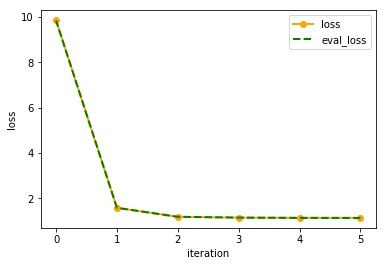

In [7]:
from google.cloud import bigquery
client = bigquery.Client()
sql = """SELECT * FROM ML.TRAINING_INFO(MODEL demo.babyweight_model_asis)"""
df = client.query(sql).to_dataframe()
# plot both lines in same graph
import matplotlib.pyplot as plt
plt.plot( 'iteration', 'loss', data=df, marker='o', color='orange', linewidth=2)
plt.plot( 'iteration', 'eval_loss', data=df, marker='', color='green', linewidth=2, linestyle='dashed')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.legend();

As you can see, the training loss and evaluation loss are essentially identical. There does not appear to be any overfitting.

## Make a Prediction with BQML using the Model

With a trained model, it is now possible to make a prediction on the values. The only difference from the second query above is the reference to the model. The data has been limited (`LIMIT 100`) to reduce amount of data returned.

When the `ml.predict` function is leveraged, output prediction column name for the model is `predicted_<label_column_name>`.

The query results show the actual weight at time of birth and the predicted weight based upon your model.

With relative ease you were able to create a useful ML model with only SQL commands.

In [14]:
%%bigquery
SELECT
  *
FROM
  ml.PREDICT(MODEL demo.babyweight_model_asis,
      (SELECT
        weight_pounds,
        CAST(is_male AS STRING) AS is_male,
        mother_age,
        CAST(plurality AS STRING) AS plurality,
        gestation_weeks
      FROM
        publicdata.samples.natality
      WHERE
        year > 2000
        AND gestation_weeks > 0
        AND mother_age > 0
        AND plurality > 0
        AND weight_pounds > 0
    ))
LIMIT 100

,predicted_weight_pounds,weight_pounds,is_male,mother_age,plurality,gestation_weeks
0,7.208956,8.187968,true,25,1,38
1,7.620006,5.000084,false,33,1,40
2,7.156963,8.333474,false,23,1,39
3,8.475888,7.749249,true,37,1,42
4,7.557302,7.561856,false,30,1,40
...,...,...,...,...,...,...
95,6.819329,7.473671,false,19,1,38
96,7.295774,7.438397,true,17,1,39
97,8.083048,7.125340,false,43,1,41
98,7.612507,8.126239,true,20,1,40


## Conclusion

This concludes your lab and introduction to BigQuery ML.  

<br>
<br>
<br>
<br>
Copyright 2018 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License